# Загружаем необходимые модули

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Подготовка к обработке данных

## Описание датасета
**Поля данных:**
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

**Таргет**
* Price - цена квартиры

## Загружаем предоставленные нам файлы

In [2]:
train = pd.read_csv('train.csv') #обучающий набор
test = pd.read_csv('test.csv') #тестовый набор
sample = pd.read_csv('sample_submission.csv') #образец файла представления в правильном формате

## Оцениваем тестовый датасет

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

**Как мы видим:**
* В датасете имеется 10000 позиций;
* Данный датасет занимает 1.5+ MB памяти;
* В нем имеются float64(8), int64(9), object(3) типы данных;
* А также всего 20 колонок.

Сразу убираем колонку Price в отдельную переменную, чтобы она не мешала нам при дальнейшей обработке данных

In [4]:
train_target = train.pop('Price')

Продолжаем оценку имеющихся данных

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


**Сразу можно отметить:**
* LifeSquare и Healthcare_1 имеют менее 10000 позиций, следовательно там имеются пропущенные значения;
* Минимальные значения Rooms, KitchenSquare и HouseFloor равны 0, что не может соответсвовать реальности;
* Минимальные значения Square и LifeSquare также слишком малы, чтобы соответствовать действительности.

Смотрим какие значения есть в колонке LifeSquare

In [6]:
train.LifeSquare.describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

Уже можно отметить, что имеются максимальные значения слишком высоки

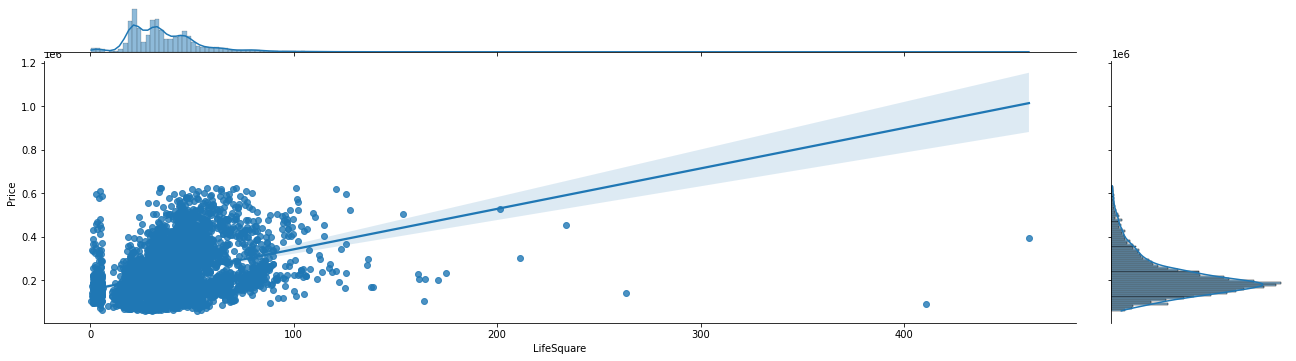

In [7]:
train_temp = train.loc[train['LifeSquare']<500]
grid = sns.jointplot(train_temp['LifeSquare'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

Видно, что лучше будет ограничится значениями до 100, а все остальное считать выбросами

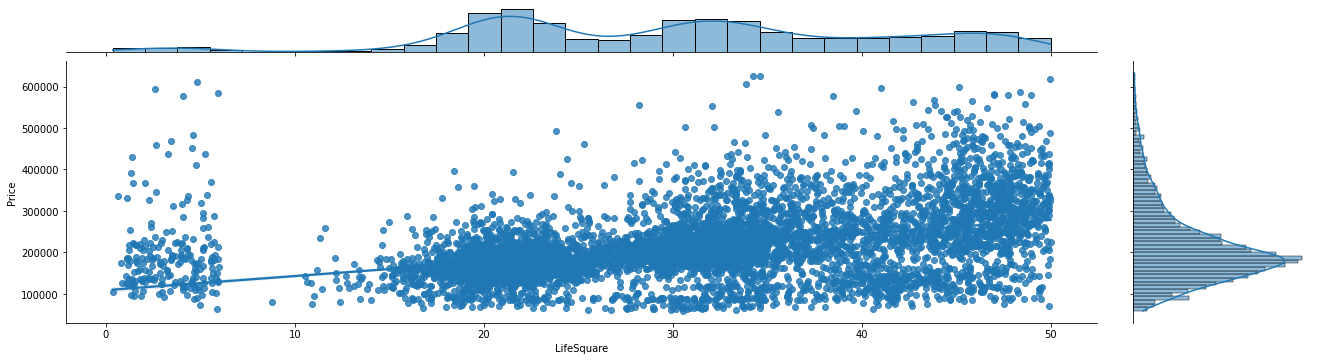

In [8]:
train_temp = train.loc[train['LifeSquare']<50]
grid = sns.jointplot(train_temp['LifeSquare'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

У минимальных значений будем считать за выбросы все значения меньше 10

Смотрим какие значения имеются у колонки Rooms

In [9]:
train.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

**Как мы видим у значений Rooms имеются:**
* 8 позиций нулевых значений;
* а также 4 позиции со значениями 6, 10 и 19

Их будем считать за выбросы и от них нужно будет избавиться.

Смотрим какие значения имеются у колонки KitchenSquare

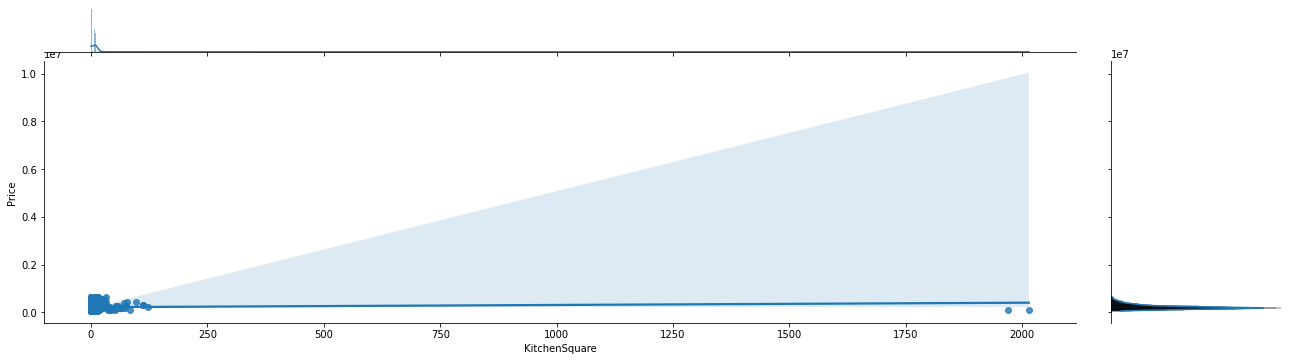

In [10]:
grid = sns.jointplot(train['KitchenSquare'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

Сразу отсекаем все значения выше 250

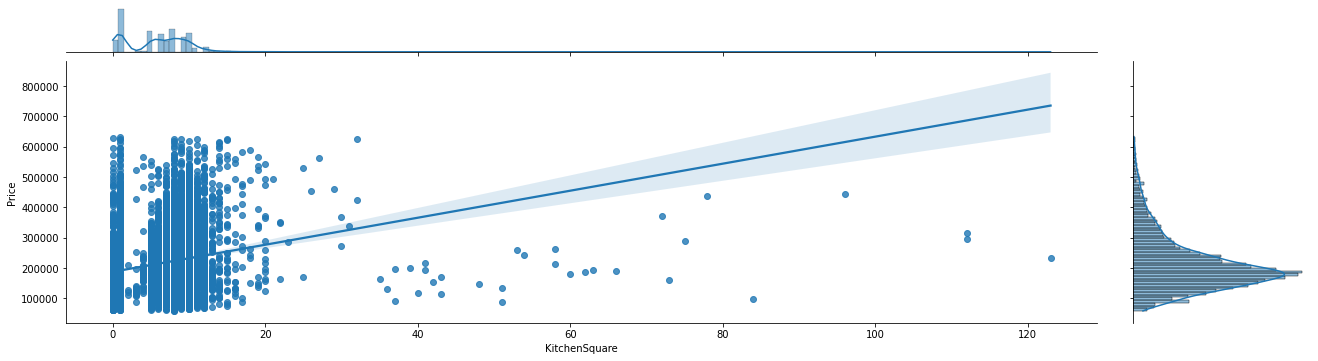

In [11]:
train_temp = train.loc[train['KitchenSquare']<250]
grid = sns.jointplot(train_temp['KitchenSquare'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

Видим что основная масса значений сфокусированна до 20, соответсвенно все что больше 20 будем считать выбросами.

Теперь посмотрим, что со значениями близкими к 0

In [12]:
train_temp = train.loc[train['KitchenSquare']<10]

train_temp.KitchenSquare.value_counts()

1.0    2460
8.0    1306
5.0    1169
6.0    1038
9.0     843
0.0     697
7.0     609
4.0      39
3.0      22
2.0       4
Name: KitchenSquare, dtype: int64

Видим что значений меньше 5 мало, за исключением значений 1 и 0, что не может соответсвовать реальности.<br>
Таким образом все что меньше 5 также будет считать выбросами

Далее оцениваем позицию HouseFloor

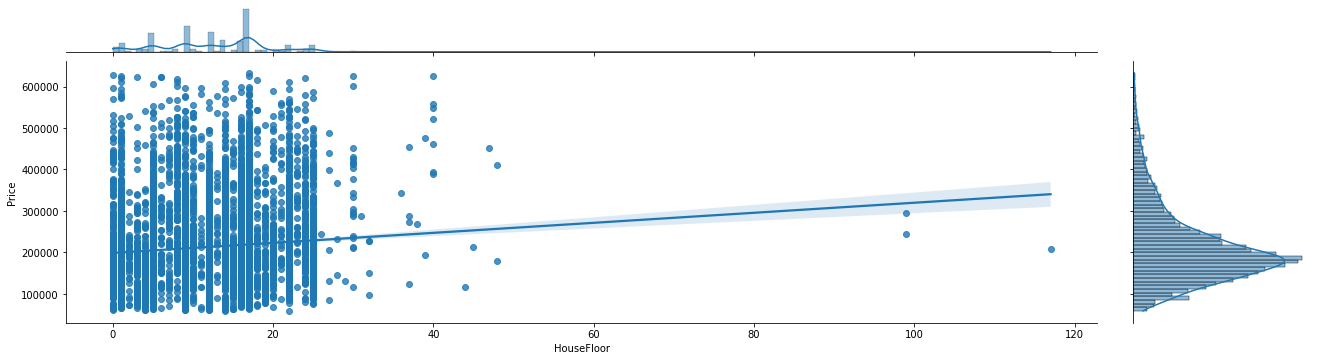

In [13]:
grid = sns.jointplot(train['HouseFloor'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

Все что больше 40 будем, а также нулевые значения будем считать выбросами

И под конец оцениваем колонку Square

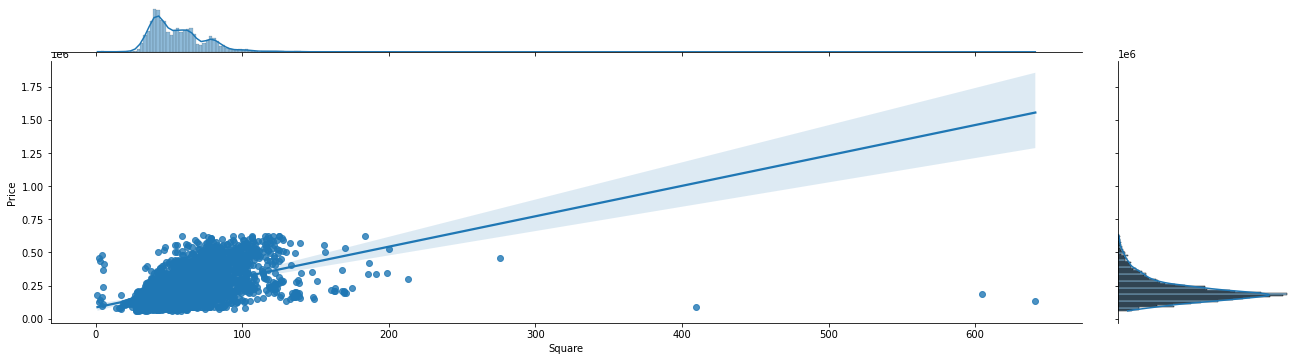

In [14]:
grid = sns.jointplot(train['Square'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

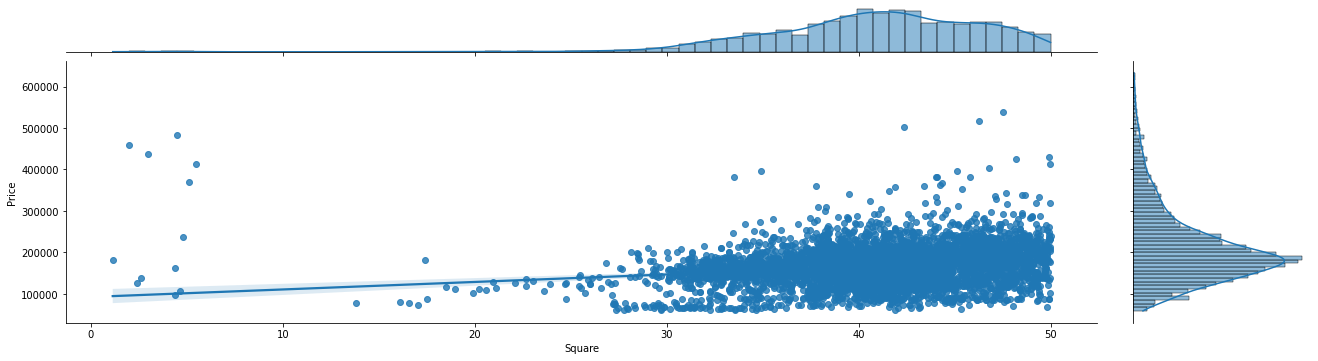

In [15]:
train_temp = train.loc[train['Square']<50]
grid = sns.jointplot(train_temp['Square'], train_target, kind='reg')
grid.fig.set_figwidth(20)
grid.fig.set_figheight(5)

Все что больше 200 и меньше 25 будем считать выбросами

## Обрабатываем тестовый датасет

### Создаем необходимые для обработки данных функции

In [16]:
#Функция удаляющая из датафрейма переданную колонку
def delite(df, column):
    df.pop(column)
    
#Функция которая меняет значения с типа object на int32, где A = 0, B = 1
def replace(df, column):
    value_dict = {'A': 0, 'B': 1}
    for x, y in value_dict.items(): df.loc[(df[column] == x), column] = y
    return df.astype({column: np.int64})

#Функция ограничивающая значения у переданной колонки датасета
def blowout(df, column, x, y):
    df.loc[(df[column] < x), column] = x
    df.loc[(df[column] > y), column] = y
    
#Функция уменьшающая размер датасета
def reduce_mem_usage(df):    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')  
            
    return df

### Теперь обрабатываем имеющиеся данные

In [17]:
def preparation(df):
    #Первым делом заполняем пустые LifeSquare значения средним:
    df.LifeSquare = df.LifeSquare.fillna(df.LifeSquare.mean())
    
    #Далее обрабатываем выбросы:
    t = pd.DataFrame([['Rooms', 1, 5],
                      ['KitchenSquare', 5, 20],
                      ['HouseFloor', 1, 40],
                      ['Square', 25, 200],
                      ['LifeSquare', 10, 100]],
                     columns = ['name', 'min', 'max'])
    
    for i in range(len(t)):blowout(df, t.loc[i][0], t.loc[i][1], t.loc[i][2])
    
    #Заполняем пропущенные значения Healthcare_1 на основании его среднего значения в опредленном DistrictId
    H1_DId = df.groupby('DistrictId', as_index=False).agg({'Healthcare_1': 'mean'})
    H1_DId.Healthcare_1 = H1_DId.Healthcare_1.fillna(H1_DId.Healthcare_1.mean())
    for i in (H1_DId.DistrictId):
        column = ['DistrictId','Healthcare_1']
        new_value = int(H1_DId.loc[H1_DId.DistrictId == i, 'Healthcare_1'])
        df.loc[df.DistrictId == i, column] = df.loc[df.DistrictId == i, column].fillna(new_value)
    
    #Меняем тип с object на int у значений Ecology_2, Ecology_3, Shops_2
    for i in ['Ecology_2', 'Ecology_3', 'Shops_2']: df = replace(df, i)    
    
    #И в конце уменьшаем размер нашего датасета
    df = reduce_mem_usage(df)
    
    return df

In [18]:
train = preparation(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   DistrictId     10000 non-null  int16  
 2   Rooms          10000 non-null  float16
 3   Square         10000 non-null  float16
 4   LifeSquare     10000 non-null  float16
 5   KitchenSquare  10000 non-null  float16
 6   Floor          10000 non-null  int8   
 7   HouseFloor     10000 non-null  float16
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float16
 10  Ecology_2      10000 non-null  int8   
 11  Ecology_3      10000 non-null  int8   
 12  Social_1       10000 non-null  int8   
 13  Social_2       10000 non-null  int16  
 14  Social_3       10000 non-null  int16  
 15  Healthcare_1   10000 non-null  float16
 16  Helthcare_2    10000 non-null  int8   
 17  Shops_1        10000 non-null  int8   
 18  Shops_2

# Обучаем модель

Обучаем модель

In [19]:
model = RandomForestRegressor(n_estimators=1000, max_depth=12.2, max_features = 18, random_state=66)

model.fit(train, train_target.values)

RandomForestRegressor(max_depth=12.2, max_features=18, n_estimators=1000,
                      random_state=66)

Делаем предсказания

In [20]:
test = preparation(test)

check_pred = pd.DataFrame({"Id": test.Id, "Price": model.predict(test).flatten()})

Сохраняем полученные результаты

In [21]:
check_pred.to_csv('result.csv', index=False, sep=',')

# Ник на Kagle: SergeyAY 
# Оценка: 0.72681